In [1]:
import logging
import time
import json
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import TwoQubitWeylDecomposition

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli, random_su4
from pauli_propagation.gates import QuantumGate
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation import staircasetopology2d_qc
from pauli_propagation.decomposition import su4_kak_reconstruct, su4_kak_decomp


# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli

# Construct a single-qubit circuit with one Hadamard gate
qc = QuantumCircuit(1)
qc.t(0)

n = qc.num_qubits
# Initial observable: X on qubit 0
pauli_label = 'X'
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, n)
product_label = "+" * n  # Initial state |+>

# Create the propagator and propagate
prop = PauliPropagator(qc)
# For a single circuit, max_weight=3 has no effect
layers = prop.propagate(init_term, max_weight=3)  # [[+1*X], [+0.707107*X, -0.707107*Y]]

exp = prop.expectation_pauli_sum(layers[-1], product_label)
print(exp) # 0.7071067811865475


Propagating, max weight: 3:   0%|          | 0/1 [00:00<?, ?it/s]

0.7071067811865475


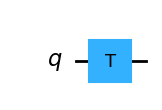

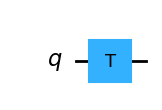

In [8]:
qc.draw(output='mpl', fold=-1)

In [5]:
layers

[[+1*X], [+0.707107*X, -0.707107*Y]]

In [ ]:
nx = ny = 4
L = 1

# Construct the circuit and initial PauliTerm
qc_2d = staircasetopology2d_qc(nx, ny, L)
qc_2d.draw(output='mpl', fold=-1)

n = qc_2d.num_qubits
pauli_label = 'Z' + "I" * (n - 1)
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, n)
product_label = "0" * n
prop_2d = PauliPropagator(qc_2d)

layers_2d = prop_2d.propagate(init_term, max_weight=3, use_parallel=False)

exp_2d = prop_2d.expectation_pauli_sum(layers_2d[-1], product_label)
print(exp_2d)


Propagating, max weight: 3:   0%|          | 0/24 [00:00<?, ?it/s]

Propagating, max weight: 3:   0%|          | 0/24 [00:00<?, ?it/s]

-0.021014576792048642


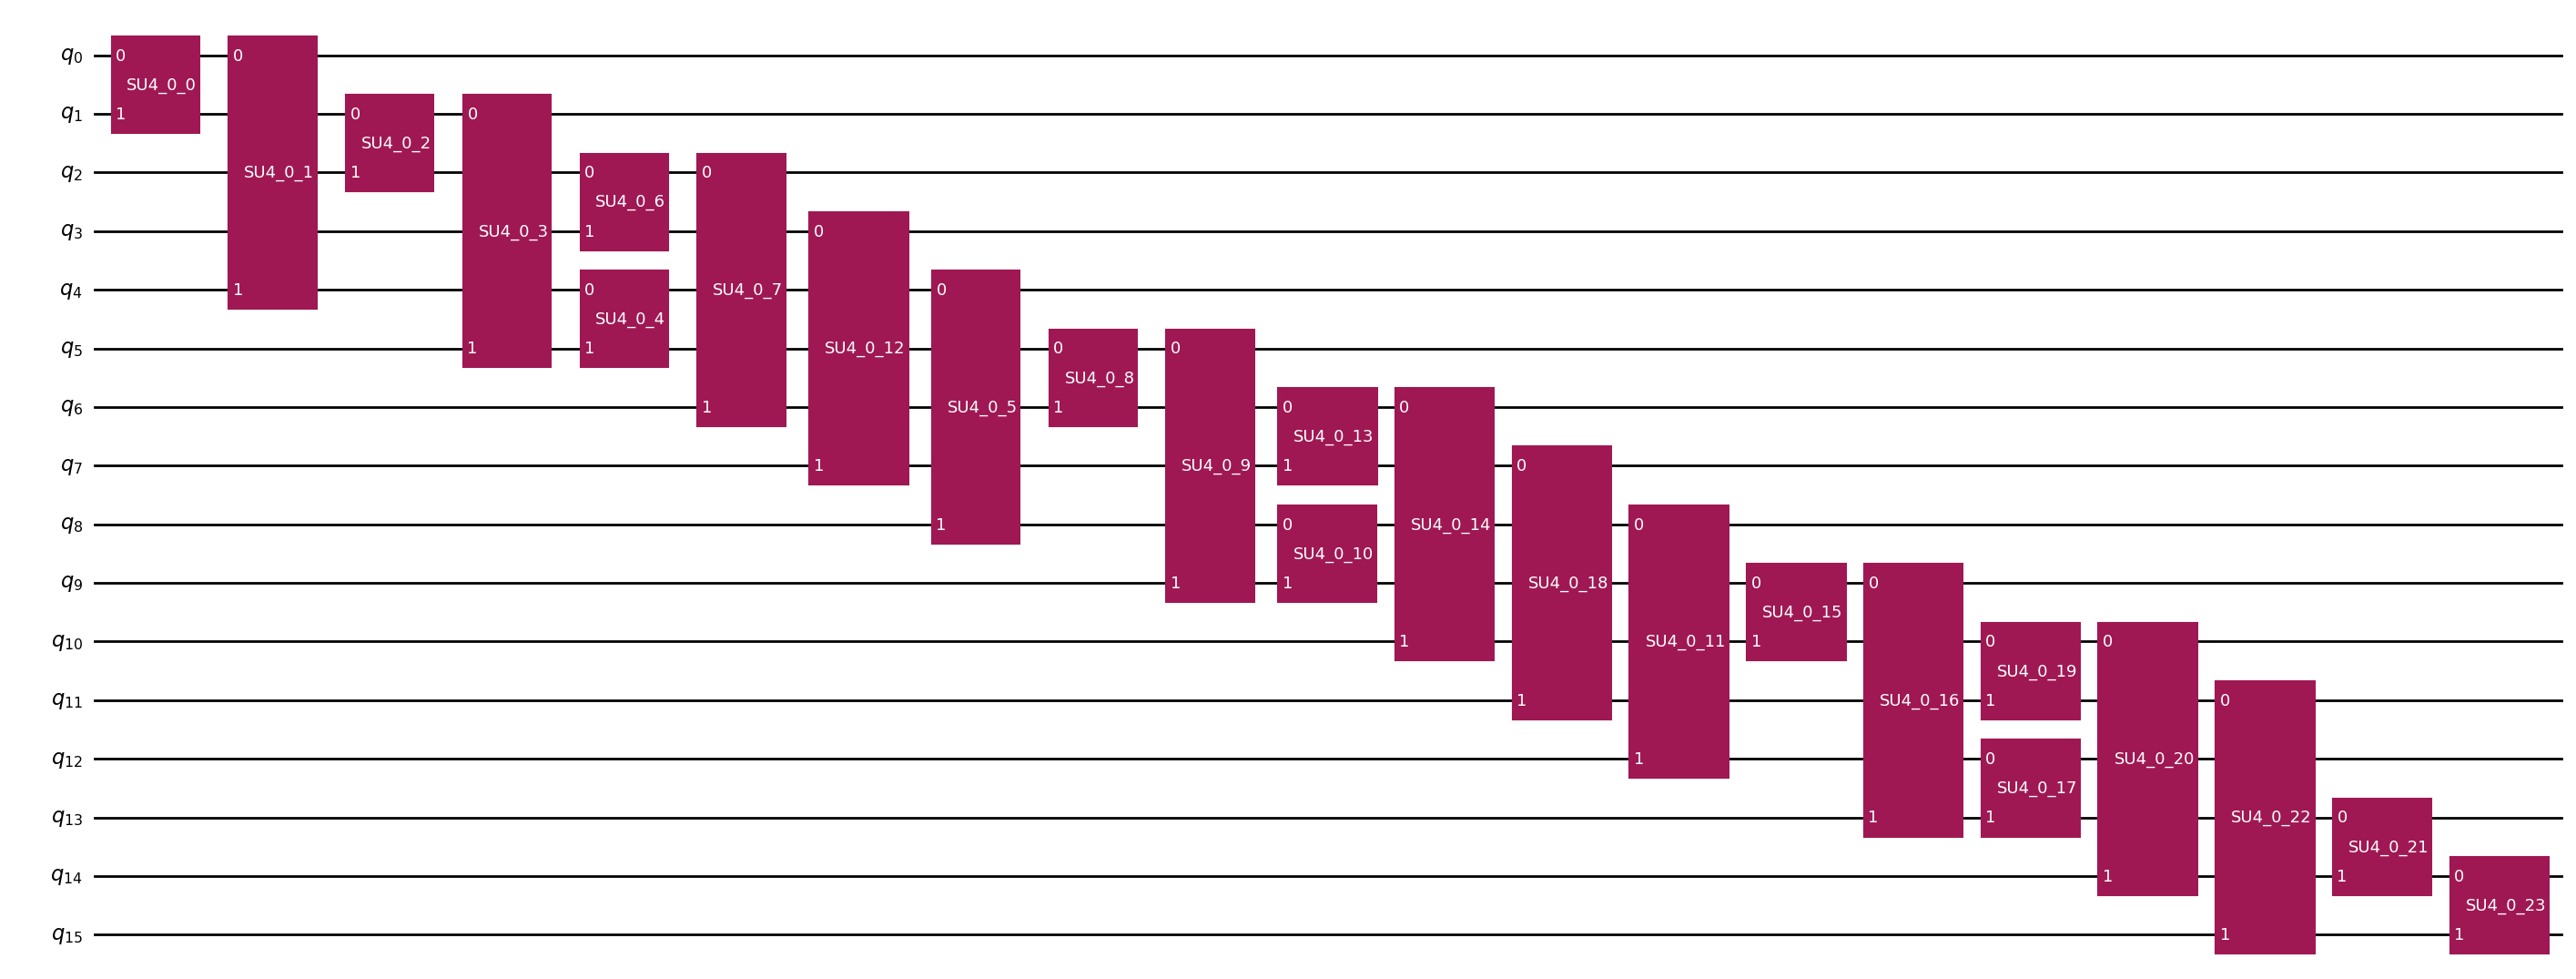

In [3]:
nx, ny = 4, 4
L = 1

# Construct the circuit and initial PauliTerm
qc_2d = staircasetopology2d_qc(nx, ny, L)
qc_2d.draw(output='mpl', fold=-1)

n = qc_2d.num_qubits
pauli_label = 'Z' + "I" * (n - 1)
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, n)
product_label = "0" * n
prop_2d = PauliPropagator(qc_2d)

layers_2d = prop_2d.propagate(init_term, max_weight=3, use_parallel=False)

exp_2d = prop_2d.expectation_pauli_sum(layers_2d[-1], product_label)
print(exp_2d)

In [4]:
sv = Statevector.from_instruction(qc_2d)
P = Pauli(pauli_label)
exp_sv = np.real_if_close(sv.expectation_value(P))
print("Statevector expectation:", exp_sv)

Statevector expectation: -0.03282397095090454


Propagating, max weight: 3:   0%|          | 0/360 [00:00<?, ?it/s]

-0.028760477367676136


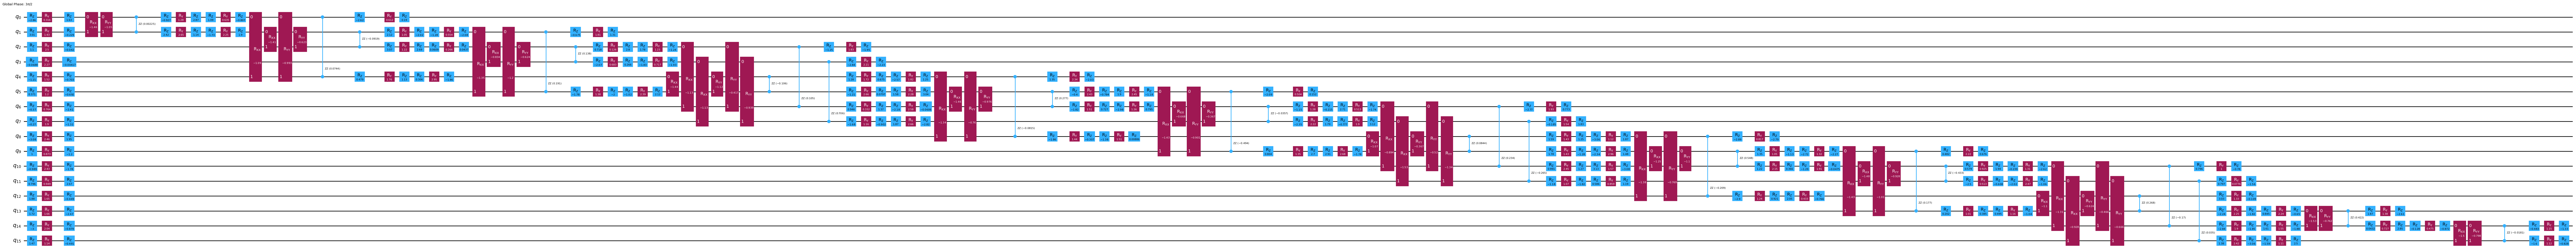

In [5]:
qc_2d_kak = su4_kak_reconstruct(qc_2d)

qc_2d_kak.draw(output='mpl',fold= -1);

prop_kak_2d = PauliPropagator(qc_2d_kak)

layers_kak_2d = prop_kak_2d.propagate(init_term, max_weight=3, use_parallel=False)

exp_kak_2d = prop_kak_2d.expectation_pauli_sum(layers_kak_2d[-1], product_label)
print(exp_kak_2d)

In [6]:
# L = 1, 15w samples
# L = 2, 30w samples

nx, ny = 5,5
L_vals = [4]            
M = 10000 * 1500
max_kk = 6

# Prepare the output directory
out_dir = f"results/kak_{nx}_{ny}"
os.makedirs(out_dir, exist_ok=True)

In [7]:
for L in L_vals:

    # Construct circuit & initial PauliTerm 
    qc_2d = staircasetopology2d_qc(nx, ny, L)
    qc_2d = su4_kak_reconstruct(qc_2d)
    n = qc_2d.num_qubits

    pauli_label = 'Z' + "I" * (n - 1)
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    product_label = "0" * n
    prop_2d = PauliPropagator(qc_2d)

    # Monte-Carlo sampling with persistence support 
    mc = MonteCarlo(qc_2d)
    
    # Define sample file path for this L
    sample_file = os.path.join(out_dir, f"kak_samples_L{L}.pkl")
    
    # Use persistent sampling - will load existing samples if available
    _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, 
                                                   M=M, 
                                                   sample_file=sample_file,
                                                   load_existing=True)  # Load existing samples
    
    #  Calculate weight histogram (normalized to probability density) 
    bins = np.arange(0.5, n + 1.5)
    hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)

    # calculate both it and "probability density" together
    hist_vals = hist_counts / float(len(last_weights))  # If you also want probability density

    # Estimate MC MSE for all k (cumulative and layer) 
    mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
                                                         product_label=product_label)
        
    cum   = mse_mc_results_dict['cumulative']
    layer = mse_mc_results_dict['layer']

    # Package the results for this L into a dict, containing only the content for this L ===
    result_for_L = {"L": L,
                    "weight_hist": {"hist_vals": hist_vals.tolist(),
                                    "bin_edges": bin_edges.tolist(),
                                    "hist_counts": hist_counts.tolist()},
                    "cum_mse":  { str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1) },
                    "weight_mse": { str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1) }}

    # Write to a JSON file, with the value of L in the filename 
    filename = os.path.join(out_dir, f"kak_mc_results_L{L}.json")
    with open(filename, 'w') as f:
        json.dump(result_for_L, f, indent=2, ensure_ascii=False)

    print(f"Completed MC sampling for L={L}, results saved to：{filename}")

Loading existing samples from results/kak_5_5\kak_samples_L4.pkl...
Loaded 10000000 existing samples
Generating 3000000 new samples (total target: 13000000)


MC sampling:   0%|          | 0/3000000 [00:00<?, ?it/s]

Saving 13000000 samples to results/kak_5_5\kak_samples_L4.pkl...
Completed MC sampling for L=4, results saved to：results/kak_5_5\kak_mc_results_L4.json


In [8]:
L_vals = [1,2,3,4]
mc_results_dict = {"weight_mse":  { str(k): [] for k in range(max_kk + 1) },
                   "cum_mse":     { str(k): [] for k in range(max_kk + 1) },
                   "weight_hist": {}}

# For each L, open the corresponding JSON file, load the data, and append it to mc_results_dict
for L in L_vals:
    filename = os.path.join(out_dir, f"kak_mc_results_L{L}.json")
    with open(filename, "r") as f:
        data_L = json.load(f)

    #  Append the single-layer ΔMSE (weight_mse) and cumulative MSE (cum_mse) to their respective lists
    for k in range(max_kk + 1):
        mc_results_dict["weight_mse"][str(k)].append(data_L["weight_mse"][str(k)])
        mc_results_dict["cum_mse"][str(k)].append(data_L["cum_mse"][str(k)])

    # Also store the histogram "weight_hist": directly use the string of L as the key,
    #    the value is still a dict containing hist_vals/list and bin_edges/list
    mc_results_dict["weight_hist"][str(L)] = data_L["weight_hist"]


[0.036391, 0.007243, 0.001054, 0.000168, 3.6e-05, 9e-06]
[0.0007915, 0.000136, 3.15e-05, 8e-06, 3.5e-06, 1e-06]
[6.414285714285715e-05, 1.2571428571428572e-05, 3.2857142857142857e-06, 1.2857142857142858e-06, 1.4285714285714285e-07, 2.857142857142857e-07]
[9.923076923076923e-06, 6.923076923076923e-07, 7.692307692307692e-08, 1.5384615384615385e-07, 1.5384615384615385e-07, 0.0]


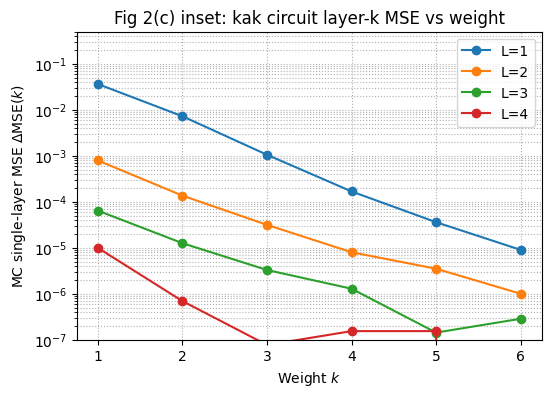

In [9]:
# —— Single-layer ΔMSE vs weight (Fig 2c) —— 
plt.figure(figsize=(6,4))
for L in L_vals:
    kk_vals = list(range(1,7))
    ys = [mc_results_dict['weight_mse'][f"{kk}"][L_vals.index(L)] for kk in kk_vals]
    print(ys)
    plt.plot(kk_vals, ys, marker='o', label=f'L={L}')
plt.yscale('log')
plt.ylim(1e-7,5e-1)  # Set the minimum value of the y-axis to 10e-8
plt.xlabel('Weight $k$')
plt.ylabel('MC single-layer MSE $\\Delta\\mathrm{MSE}(k)$')
plt.title('Fig 2(c) inset: kak circuit layer-k MSE vs weight')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


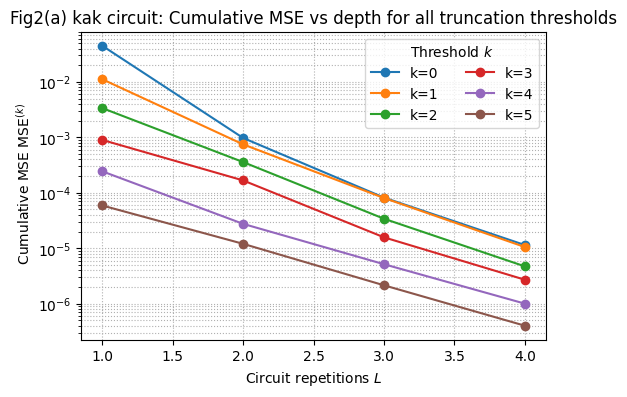

In [22]:
# —— cumulative MSE vs circuit repetitions for all kk from 0 to max_kk —— 
plt.figure(figsize=(6, 4))
for kk in range(0,6):
    ys = mc_results_dict['cum_mse'][f"{kk}"]   # list of length len(L_vals)
    plt.plot(L_vals, ys, marker='o', label=f'k={kk}')
plt.yscale('log')
plt.xlabel('Circuit repetitions $L$')
plt.ylabel(' Cumulative MSE $\\mathrm{MSE}^{(k)}$')
plt.title('Fig2(a) kak circuit: Cumulative MSE vs depth for all truncation thresholds')
plt.legend(title='Threshold $k$', ncol=2)
plt.grid(True, which='both', ls=':')
plt.show()

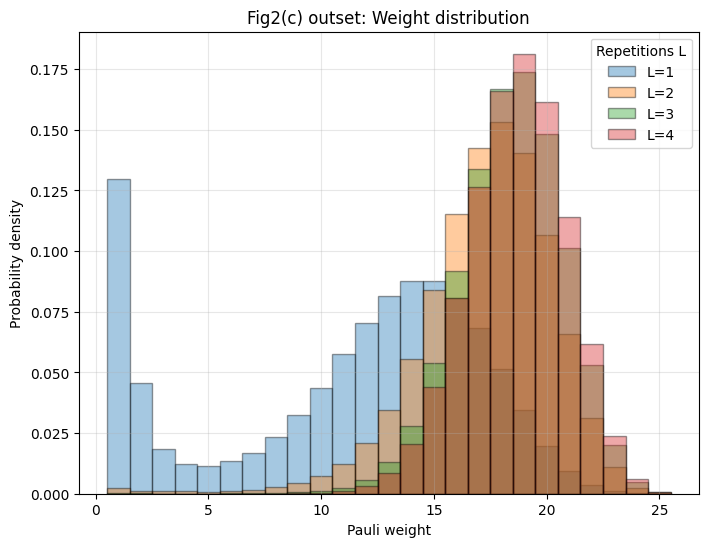

In [18]:
plt.figure(figsize=(8,6))

for L in L_vals:
    entry     = mc_results_dict['weight_hist'][str(L)]  # Note: Use str(L) or your already converted int key
    hist_vals = entry['hist_vals']    # Already a float list
    bin_edges = entry['bin_edges']    # Already a float list, length = len(hist_vals)+1

    # calculate the difference between each pair of adjacent boundaries
    widths = [b2 - b1 for b1, b2 in zip(bin_edges[:-1], bin_edges[1:])]

    # Plotting the bar chart
    plt.bar(bin_edges[:-1], hist_vals, width=widths,
            align='edge', edgecolor='black', alpha=0.4, label=f"L={L}")

plt.xlabel("Pauli weight")
plt.ylabel("Probability density")
plt.title(f"Fig2(c) outset: Weight distribution")
plt.legend(title="Repetitions L")
plt.grid(alpha=0.3)
plt.show()


In [12]:
k_vals = [1,2,3,4]
L_vals = [4]
nx = ny = 5

# for L in L_vals:
#     # Initialize dictionaries to collect results for this specific L
#     prop_results_dict = {'prop_time':    {k: [] for k in k_vals},
#                          'exp_time':     {k: [] for k in k_vals},
#                          'expectation':  {k: [] for k in k_vals}}

#     # Build the 2D circuit and initial PauliTerm
#     qc_2d = staircasetopology2d_qc(nx, ny, L)
#     qc_2d = su4_kak_reconstruct(qc_2d)
#     n = qc_2d.num_qubits
#     pauli_label = "X" + "I" * (n - 1)
#     key = encode_pauli(Pauli(pauli_label))
#     init_term = PauliTerm(1.0, key, n)
#     prop_2d = PauliPropagator(qc_2d)

#     # For each k, propagate and measure, then store timing and expectation
#     for k in k_vals:
#         t0 = time.time()
#         layers_trunc = prop_2d.propagate(init_term, max_weight=k, 
#                                          return_history=False, 
#                                          use_parallel=False)
#         t_prop = time.time() - t0

#         t1 = time.time()
#         est_exp = prop_2d.expectation_pauli_sum(layers_trunc, "0" * n)
#         t_exp = time.time() - t1

#         prop_results_dict['prop_time'][k].append(t_prop)
#         prop_results_dict['exp_time'][k].append(t_exp)
#         prop_results_dict['expectation'][k].append(est_exp)

#     # Write out a JSON file for this L
#     output_path = f"results/kak/kak_prop_results_L{L}.json"
#     with open(output_path, "w") as f:
#         json.dump(prop_results_dict, f, indent=2)

#     print(f"Results for L={L} saved to {output_path}")


In [13]:
# 3min59s 709gates

In [14]:
L_vals = [1,2,3,4] # L_vals= [1,2,3,4]

# Prepare an empty merged dictionary with the same structure as before
prop_results_dict = {'prop_time':    {k: [] for k in k_vals},
                     'exp_time':     {k: [] for k in k_vals},
                     'expectation':  {k: [] for k in k_vals}}

out_dir_kak = os.path.join("results", "kak")
for L in L_vals:
    filename = os.path.join(out_dir_kak, f"kak_prop_results_L{L}.json")
    with open(filename, "r") as f:
        raw = json.load(f)

    # Combine the lists for each metric and k
    for metric, subdict in raw.items():
        for k_str, v_list in subdict.items():
            k = int(k_str)
            prop_results_dict[metric][k].extend(v_list)

# Now prop_results_dict has the exact same format as before,
# with data from all L values merged together.


FileNotFoundError: [Errno 2] No such file or directory: 'results\\kak\\kak_prop_results_L1.json'

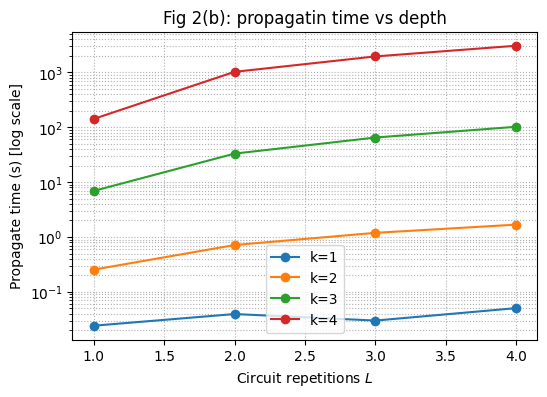

In [21]:
#  Exact truncation propagate time vs depth (Fig 2(b)), y-axis changed to log10

plt.figure(figsize=(6, 4))
for k in k_vals:
    ts = prop_results_dict['prop_time'][k]
    plt.plot(L_vals, ts, marker='o', label=f'k={k}')
plt.yscale('log')  # Switch to logarithmic scale (base 10)
plt.xlabel('Circuit repetitions $L$')
plt.ylabel('Propagate time (s) [log scale]')
plt.title('Fig 2(b): propagatin time vs depth')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()
